In [1]:
import sklearn
import skimage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
%matplotlib inline

# Struktur des Datensatzes
Eigentlich würden wir ja gerne den Datensatz einfach laden. Allerdings haben nur schon die geladenen Bilder ganz unterschiedliches Format:

In [2]:
#teste imread
im = skimage.io.imread('Bilder/test/0887-u026.png')
im.shape

(240, 240, 4)

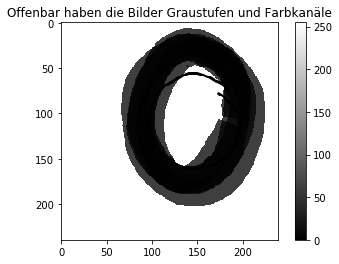

In [3]:
plt.imshow(im[:,:,0],cmap='gray')
plt.title('Offenbar haben die Bilder Graustufen und Farbkanäle')
plt.colorbar()

## Daten laden
Zunächst laden wir die Bilder in einen Dictionary:

In [4]:
mins = []
maxes=[]
imdict = dict()
for fn in glob('Bilder/train/*.png')+glob('Bilder/test/*.png'):
    im = skimage.io.imread(fn)
    imdict[fn]=im

## Farbbild nach Graustufenbild
Welche shapes gibt's denn so?

In [5]:
shapes = []
for fn,im in imdict.items():
    shapes.append(im.shape)
pd.Series(shapes).unique()[:10] #zeige nur die ersten 10 unterschiedlichen shapes.

array([(50, 50), (239, 239, 4), (10, 10), (91, 96, 3), (256, 256, 4),
       (80, 80, 4), (100, 100, 3), (100, 100, 4), (50, 50, 4),
       (84, 84, 4)], dtype=object)

Dass die Bilder unterschiedlich gross sind, ist ja klar. Die werden wir mit 
`skimage.transform.resize` reskalieren. Aber warum haben wir teilweise 3 oder 4 Farbkanäle? Schauen wir uns diese Bilder genauer an:

done.


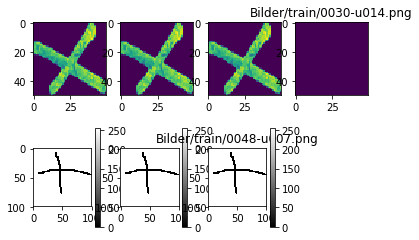

In [6]:
seen3=0 
seen4=0
for fn,im in imdict.items():
    if len(im.shape)>2:
        if im.shape[2]==4:
            seen4+=1
            if seen4==5: #5. Bild mit 4 Ebenen
                plt.subplot(2,4,1)
                plt.imshow(im[:,:,0])
                plt.subplot(2,4,2)
                plt.imshow(im[:,:,1])
                plt.subplot(2,4,3)
                plt.imshow(im[:,:,2])
                plt.subplot(2,4,4)
                plt.imshow(im[:,:,3])
                plt.title(fn)
        elif im.shape[2]==3:
            seen3+=1
            if seen3==3:#Zeige das 3. Bild mit 3 Ebenen
                plt.subplot(2,4,5)
                plt.imshow(im[:,:,0],cmap='gray')
                plt.colorbar()
                plt.subplot(2,4,6)
                plt.imshow(im[:,:,1],cmap='gray')
                plt.colorbar()
                plt.subplot(2,4,7)
                plt.imshow(im[:,:,2],cmap='gray')
                plt.colorbar()
                plt.title(fn)
print('done.')

Die Arrays, haben 1, 3 oder 4 Ebenen. 1 Ebene entspricht einem einfachen Graustufenkanal, 3 Ebenen einem RGB-Bild, und 4 Ebenen einem RGBA-Bild (mit Alpha-Kanal). Wir erstellen uns Graustufenbilder, indem wir einfach über die Farbkanäle mitteln:   

In [7]:
grayimdict = dict()

for fn,im in imdict.items():
    if len(im.shape)!=2:
        assert len(im.shape)==3,'unerwarteter Fall'
        im=np.mean(im,axis=2)
    grayimdict[fn]=im

### Wertebereich der Pixel
Welche Wertebereiche haben die Pixel? Wir möchten diese auf den Bereich 0 (Schwarz) bis 1 (Weiss) einschränken.

In [8]:
for fn,im in grayimdict.items():
    mins.append(np.min(im))
    maxes.append(np.max(im))

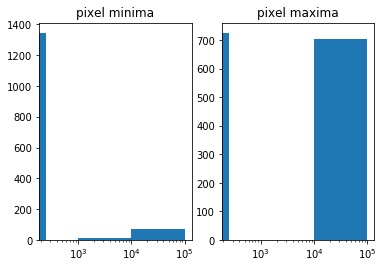

In [9]:
ax1 = plt.subplot(1,2,1)
plt.hist(mins,bins=[0,256,1000,10000,100000]);plt.title('pixel minima')
ax1.set_xscale("log", nonposx='clip')
ax2 = plt.subplot(1,2,2)
plt.hist(maxes,bins=[0,256,1000,10000,100000]);plt.title('pixel maxima')
ax2.set_xscale("log", nonposx='clip')
#ax2.set_yscale("log", nonposy='clip')

Die Pixel haben entweder den Wertebereich [0,255] oder [0,2^16-1]
   
Wir normieren also mal Pixel-Wertebereich:

In [10]:
scaledimdict = {}
for fn,im in grayimdict.items():
    imscaled = (im - np.min(im))/(np.max(im)-np.min(im))
    scaledimdict[fn]=imscaled

In [11]:
scaledimdictflipped = scaledimdict.copy()
perc_list = []
for fn,im in scaledimdict.items():
    curr_perc = np.percentile(im.ravel(),50)
    if curr_perc > 0.5:        
        scaledimdictflipped[fn] = 1-im
        new_perc = np.percentile(scaledimdictflipped[fn].ravel(),50)
    perc_list.append(curr_perc)

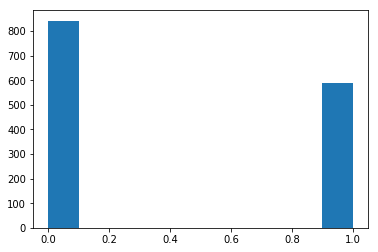

In [12]:
plt.hist(perc_list);

Das ist erstaunlich eindeutig- es gibt klar zwei Gruppen, eine mit kleinem und eine mit grossem Median. Da die meisten Pixel Hintergrundpixel sein sollen, erwarten wir, dass das 50%-Quantil die Hintergrundfarbe angibt.
   

## Auflösung der Bilder reduzieren"
   
Wir skalieren nun die Bilder drastisch runter- eine Unterscheidung von \"x,o,+\" sollte auch mit 15x15-Bildern gut möglich sein."
   

In [13]:
resizedimdict=dict()
for fn,im in scaledimdictflipped.items():
    im = skimage.transform.resize(im,(15,15),
              #Diese zwei Optionen sind nötig, um keine Warung mehr zu erhalten:
              anti_aliasing=True, 
              mode='reflect')
    resizedimdict[fn]=im

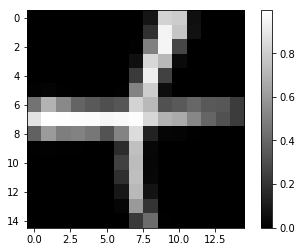

In [14]:
plt.imshow(im,cmap='gray')
plt.colorbar()

(1430, 225)

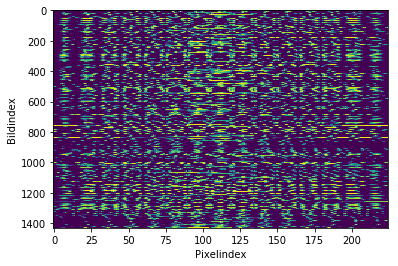

In [15]:
pixelList = []
fnamelist = []
for fn,im in resizedimdict.items():
    pixelList.append(im.ravel().tolist())
    fnamelist.append(fn)
pixelArr = np.array(pixelList)
plt.imshow(pixelArr)
plt.gca().set_aspect('auto');plt.xlabel('Pixelindex');plt.ylabel('Bildindex')

pixelArr.shape #Anz. Bilder x Anz Pixel (15x15)

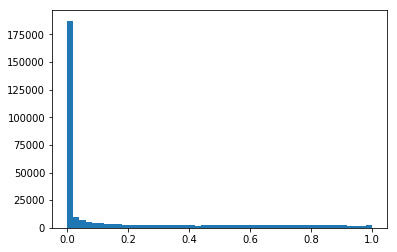

In [16]:
#Verteilung aller Pixelwerte: 
plt.hist(pixelArr.ravel(),bins=50);

In [17]:
import pandas as pd
cols = ['pix'+str(i) for i in range(15**2)]
df = pd.DataFrame(pixelArr,columns=cols,index=fnamelist)
df.shape

(1430, 225)

# Binarisierung

Wie können wir diese Daten binarisieren? Wenn wir alle Pixelwerte grösser als ein Schwellwert auf Eins und darunter auf Null setzen: Wo wählen wir den Schwellwert?  
Wenn Wir einen Wert zwischen 0.01 und 0.1 wählen, erhalten wir Probleme mit folgenden Bildern:

In [18]:
problemBilder = (215-pd.isnull(df[(df>0.01) & (df < 0.1)]).sum(axis=1))

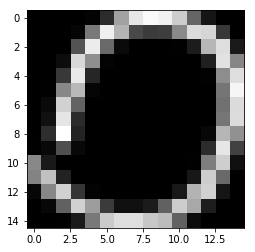

In [19]:
#z.B. 
testbild = problemBilder.sample()
plt.imshow(resizedimdict[testbild.index[0]],cmap='gray')

Tatsächlich sollten die meisten dieser Bilder kein grosses Problem darstellen für die Klassifikation. Sie haben eine klare Form, und die Pixel mit Werten zwischen 0.01 und 0.1 sollten nicht entscheidend sein.

In [20]:
#Wende den Schwellwert an: 
dfbin = df.copy()
dfbin[df>0.1]=1
dfbin[df<=0.1]=0
dfbin = dfbin.astype('int')

Text(0,0.5,'Bildindex')

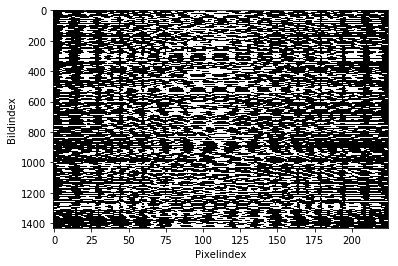

In [21]:
#Überprüfe qualitativ, indem wir alle Bilder in einem zusammenfassen. Oder auch einfach, weil's hübsch aussieht...
plt.imshow(dfbin,cmap='gray')
plt.gca().set_aspect('auto');plt.xlabel('Pixelindex');plt.ylabel('Bildindex')

/home/toedtli/.virtualenvs/v_py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/toedtli/.virtualenvs/v_py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/toedtli/.virtualenvs/v_py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


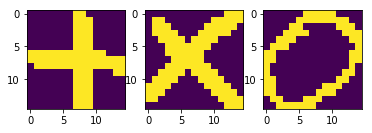

In [22]:
im1 = dfbin.sample(1).as_matrix().reshape(15,15);plt.subplot(1,3,1);plt.imshow(im1);
im2 = dfbin.sample(1).as_matrix().reshape(15,15);plt.subplot(1,3,2);plt.imshow(im2);
im3 = dfbin.sample(1).as_matrix().reshape(15,15);plt.subplot(1,3,3);plt.imshow(im3);

## Zielvariable dazuladen
Die Zielvariable zu laden ist tricky! 
Wie stellen wir sicher, dass das richtige Target-label zur richtigen Datei zugeordnet wird? Dazu müssen wir aus dem Dateinamen den Index (als Zahl) extrahieren.

Wir holen den Bildindex aus dem Dateinamen, und führen es mit dem richtigen Label aus der Zielvariablen-Datei zusammen. Die Datei ist zwar schnell geladen:

In [23]:
dfy = pd.read_csv('Bilder/target_info_train.txt',index_col='id')
dfy.sort_index(inplace=True) #wohl nicht nötig...

dfy.tail()

,target
id,
710,1
711,0
712,1
713,1
714,0


In [24]:
dfbin.tail()

,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,...,pix215,pix216,pix217,pix218,pix219,pix220,pix221,pix222,pix223,pix224
Bilder/test/1282-u002.png,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
Bilder/test/1193-u026.png,0,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
Bilder/test/1116-u019.png,0,0,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
Bilder/test/1103-u015.png,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
Bilder/test/0883-u015.png,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0


In [25]:
#extrahiere den Dateinamen aus dem Index:
image_index = dfbin.index
dfbin2 = dfbin.reset_index(inplace=False);
dfbin2.head()

,index,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,...,pix215,pix216,pix217,pix218,pix219,pix220,pix221,pix222,pix223,pix224
0,Bilder/train/0028-u009.png,0,0,0,0,0,0,0,1,1,...,0,0,1,1,1,0,0,0,0,0
1,Bilder/train/0423-u026.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bilder/train/0007-u021.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,Bilder/train/0657-u000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bilder/train/0201-u018.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [26]:
dfbin2.rename(columns={'index':'Dateiname'},inplace=True)

Hier benutzen wir eine Regex `Bilder\\/(train|test)\\/(?P<imgind>\\d+)-u\\d+.png`, umd die 4 Ziffern nach "Bilder/train/" oder "Bilder/test/" zu extrahieren. Sie werden in der Gruppe "imgind" abgelegt, und von dort wieder geholt:

In [27]:
repl = lambda m:m.group('imgind')
image_index = dfbin2['Dateiname'].str.replace('Bilder\\/(train|test)\\/(?P<imgind>\\d+)-u\\d+.png',repl).astype('int')
image_index
dfbin2['image_index']=image_index
dfbin2 = dfbin2.set_index('image_index',inplace=False).sort_index()
dfbin2.tail()

,Dateiname,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,...,pix215,pix216,pix217,pix218,pix219,pix220,pix221,pix222,pix223,pix224
image_index,,,,,,,,,,,,,,,,,,,,,
1425,Bilder/test/1425-u011.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1426,Bilder/test/1426-u010.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1427,Bilder/test/1427-u020.png,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
1428,Bilder/test/1428-u028.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1429,Bilder/test/1429-u005.png,0,0,0,0,1,1,1,1,1,...,0,1,1,1,1,0,0,0,0,0


Die Testbilder haben natürlich kein Label! Es gibt folgende Varianten von joins: 
 - inner join: es verfallen alle Zeilen, welche es nicht in beiden Teildatensätzen gibt.
 - left join: Alle spalten des "linken" Datensatzes werden behalten. Wo keine Werte vorhanden sind, wird NaN eingefügt.

In [28]:
dfbin2.tail(2)

,Dateiname,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,...,pix215,pix216,pix217,pix218,pix219,pix220,pix221,pix222,pix223,pix224
image_index,,,,,,,,,,,,,,,,,,,,,
1428,Bilder/test/1428-u028.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1429,Bilder/test/1429-u005.png,0,0,0,0,1,1,1,1,1,...,0,1,1,1,1,0,0,0,0,0


In [29]:
#inner join:
df_train = pd.merge(dfbin2, dfy, left_index=True, right_index=True)
df_train.head(2)

,Dateiname,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,...,pix216,pix217,pix218,pix219,pix220,pix221,pix222,pix223,pix224,target
0,Bilder/train/0000-u012.png,0,0,0,0,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,2
1,Bilder/train/0001-u010.png,0,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,1


In [30]:
dftemp = dfbin2.join(dfy)
df_test = dftemp[dftemp.target.isnull()]
df_test.head(2)
df_test.tail(2)

,Dateiname,pix0,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,...,pix216,pix217,pix218,pix219,pix220,pix221,pix222,pix223,pix224,target
image_index,,,,,,,,,,,,,,,,,,,,,
1428,Bilder/test/1428-u028.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1429,Bilder/test/1429-u005.png,0,0,0,0,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,NaN


In [31]:
df_train.target.unique()

array([2, 1, 0])

In [32]:
#Check! nehme 5 zufällige Bilder: stimmen die Label mit den Bildern überein?
sample = df_train.sample(5)
sample.index

Int64Index([491, 434, 214, 613, 662], dtype='int64')

Erinnern wir uns:
 - Klasse 0: Kreuz
 - Klasse 1: Kreis  
 - Klasse 2: Plus

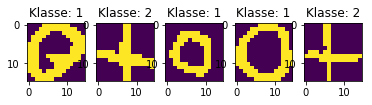

In [33]:
sample = df_train.sample(5)
for iframe,index in enumerate(sample.index):
    plt.subplot(1,5,iframe+1)
    im = sample.loc[index].iloc[1:-1].values.reshape(15,15).astype('int')
    target = sample.loc[index].target
    plt.imshow(im)
    plt.title('Klasse: {0}'.format(target))

# Speichern der Datensätze als .csv-Dateien

In [34]:
df_train.to_csv('KreuzKreisPlus_train.csv',index=True)
df_test.to_csv('KreuzKreisPlus_test.csv',index=True)

Das war's! Damit haben wir einen Datensatz in einer Form, mit der wir Machine Learning betreiben können.  
Gratulation! Einfach war das nicht! Die Dateien lagen in vielen unterschiedlichen Formaten vor. Ihr Zeitaufwand, um es bis hierhin zu schaffen, war gewiss beträchtlich. Das \"putzen\", also das standardisieren der Daten ist ein wichtiger Teil der Arbeit eines Data Scientists. Denken Sie auch daran, dass Sie gewisse Entscheidungen getroffen haben (z.B. die Auflösung, oder die Binarisierung und deren Schwellwerte), welche Sie später ev. revidieren wollen. Es lohnt sich daher der Reproduzierbarkeit des soeben erstellten Datensatzes einen gewissen Effort zu widmen.  

Als nächstes könnten wir einen Klassifikator nehmen und schauen, wie gut wir diesen Datensatz erkennen. Aber dass das Feature Engineering bei diesem Problem wichtig ist, ist wohl auch klar. "